### Imports

In [1]:
import pandas as pd
from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from gensim import corpora, models
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import plotly.express as px
from pathlib import Path
import os
import seaborn as sns
import re

### Set Source Path and load data

In [2]:
# Set Source Path
data_path = Path(os.getcwd()) / 'data'

# Load the CSV file
file_path = data_path / 'tripadvisor_hotel_reviews.csv'
data = pd.read_csv(file_path)

In [3]:
data.head()

Review  Rating
0  nice hotel expensive parking got good deal sta...       4
1  ok nothing special charge diamond member hilto...       2
2  nice rooms not 4* experience hotel monaco seat...       3
3  unique, great stay, wonderful time hotel monac...       5
4  great stay great stay, went seahawk game aweso...       5

In [4]:
data.describe()

Rating
count  20491.000000
mean       3.952223
std        1.233030
min        1.000000
25%        3.000000
50%        4.000000
75%        5.000000
max        5.000000

In [5]:
data.shape

(20491, 2)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20491 non-null  object
 1   Rating  20491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 320.3+ KB


In [7]:
data['Review'][100]

'great location staff location price make older hotel good choice, staff friendly, looking modern place not, old studio apartment building run hotel, great neighborhood close great local resturants, hotel does not sterile tourist feeling newer mid range hotels, feels like small european hotel, yes rooms use little moderizing compermise, just reservations stay,  '

<Axes: xlabel='Rating', ylabel='count'>

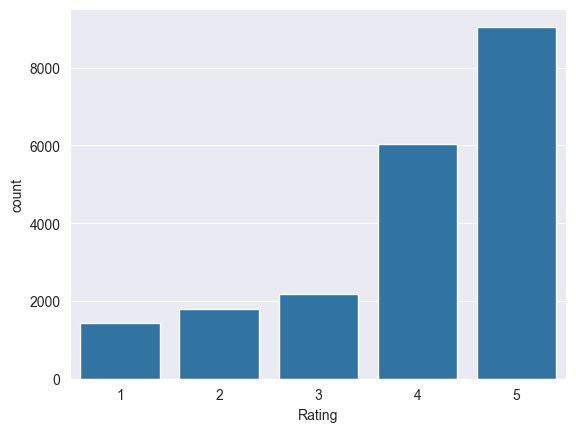

In [8]:
sns.countplot(data=data,x='Rating')

In [9]:
data.isna().sum()

Review    0
Rating    0
dtype: int64

In [10]:
def remove_html_tags(text):
    pattern = re.compile('<.*?>')
    return pattern.sub('', text)

data['Review'] = data['Review'].apply(remove_html_tags)

In [11]:
def remove_url(text):
    pattern = re.compile(r'http?://\S+|www\.\S+')
    return pattern.sub('', text)

data['Review'] = data['Review'].apply(remove_url)

In [12]:
from nltk.corpus import stopwords
StopWords = stopwords.words("english")

In [13]:
def remove_stopwords (text):
    filtered_text = ' '.join(word for word in text.split() if word.lower() not in StopWords)
    return filtered_text

data['Review']=data['Review'].apply(remove_stopwords)
data['Review'].head()

0    nice hotel expensive parking got good deal sta...
1    ok nothing special charge diamond member hilto...
2    nice rooms 4* experience hotel monaco seattle ...
3    unique, great stay, wonderful time hotel monac...
4    great stay great stay, went seahawk game aweso...
Name: Review, dtype: object

In [ ]:
!pip install pyspellchecker

In [ ]:
from spellchecker import SpellChecker  


In [ ]:
import multiprocessing
from multiprocessing import Pool
from spellchecker import Spellchecker

spell = Spellchecker()

def check_spelling_optimized(text):
    words = text.split()
    corrected_words = [spell.correction(word) if not spell.known([word]) else word for word in words]
    return ' '.join(corrected_words)


def parallelize_dataframe(df, func):
    num_cores = multiprocessing.cpu_count() - 1  # Leave one free to not freeze machine
    num_partitions = num_cores

    df_split = np.array_split(df, num_partitions)
    pool = Pool(num_cores)

    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

def apply_spell_check(df):
    df['Review'] = df['Review'].apply(check_spelling_optimized)
    return df

data = parallelize_dataframe(data, apply_spell_check)


In [ ]:
def check_spelling(text):
    textblb=TextBlob(text)
    return textblb.correct().string

data['Review']=data['Review'].apply(check_spelling)
data.head()

In [14]:
from nltk.stem import PorterStemmer
ps=PorterStemmer()
def stem_words(text):
    return " ".join([ps.stem(word) for word in text.split()])

data['Review']=data['Review'].apply(stem_words)
data.head()

Review  Rating
0  nice hotel expens park got good deal stay hote...       4
1  ok noth special charg diamond member hilton de...       2
2  nice room 4* experi hotel monaco seattl good h...       3
3  unique, great stay, wonder time hotel monaco, ...       5
4  great stay great stay, went seahawk game aweso...       5

In [15]:
def perform_sentiment_analysis(text):
    return TextBlob(text).sentiment.polarity

# Apply sentiment analysis
data['Sentiment'] = data['Review'].apply(perform_sentiment_analysis)

In [16]:
# Sentiment Distribution
fig_sentiment = px.histogram(data, x='Sentiment', nbins=20, title="Sentiment Distribution")
fig_sentiment.show()

# Rating Distribution
fig_rating = px.histogram(data, x='Rating', nbins=20, title="Rating Distribution")
fig_rating.show()

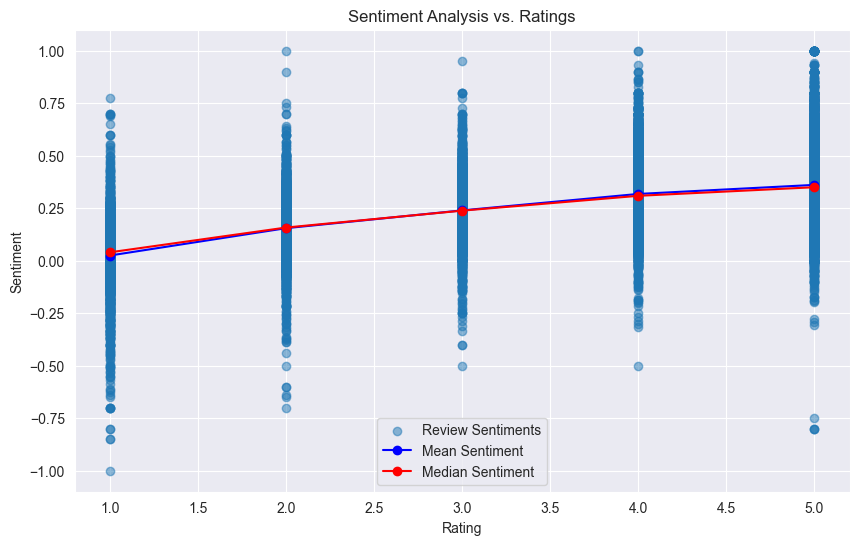

In [39]:
# Plotting sentiment against ratings
plt.figure(figsize=(10, 6))
plt.scatter(data['Rating'], data['Sentiment'], alpha=0.5, label='Review Sentiments')

# Calculate mean and median sentiments for each rating
mean_sentiments = data.groupby('Rating')['Sentiment'].mean()
median_sentiments = data.groupby('Rating')['Sentiment'].median()

# Plotting the mean and median lines
plt.plot(mean_sentiments.index, mean_sentiments.values, color='blue', label='Mean Sentiment', marker='o')
plt.plot(median_sentiments.index, median_sentiments.values, color='red', label='Median Sentiment', marker='o')

plt.title('Sentiment Analysis vs. Ratings')
plt.xlabel('Rating')
plt.ylabel('Sentiment')
plt.grid(True)
plt.legend()
plt.show()

In [18]:
def prepare_texts(reviews):
    tokenizer = RegexpTokenizer(r'\w+')
    stop_words = stopwords.words('english')
    texts = [tokenizer.tokenize(review.lower()) for review in reviews]
    texts = [[word for word in text if word not in stop_words and word.isalpha()] for text in texts]
    return texts

def lda_topic_modeling(texts, num_topics=5):
    dictionary = corpora.Dictionary(texts)
    corpus = [dictionary.doc2bow(text) for text in texts]
    lda_model = models.LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=15)
    return lda_model

texts = prepare_texts(data['Review'])
lda_model = lda_topic_modeling(texts)
lda_model.print_topics(num_words=5)


[(0,
  '0.028*"hotel" + 0.020*"stay" + 0.017*"great" + 0.013*"room" + 0.009*"nice"'),
 (1,
  '0.017*"beach" + 0.014*"resort" + 0.012*"food" + 0.012*"pool" + 0.011*"n"'),
 (2,
  '0.058*"hotel" + 0.024*"room" + 0.023*"stay" + 0.020*"great" + 0.017*"locat"'),
 (3, '0.046*"room" + 0.024*"hotel" + 0.014*"n" + 0.011*"stay" + 0.010*"bed"'),
 (4,
  '0.025*"hotel" + 0.023*"room" + 0.015*"check" + 0.012*"told" + 0.011*"desk"')]

In [ ]:
lda_model.num_topics

In [19]:
# Extract keywords using TF-IDF
def extract_keywords_tfidf(data, num_keywords=10):
    vectorizer = TfidfVectorizer(stop_words='english')
    tfidf_matrix = vectorizer.fit_transform(data['Review'])
    feature_names = vectorizer.get_feature_names_out()

    # Aggregate the scores for each word across all documents
    tfidf_scores = tfidf_matrix.sum(axis=0).A1
    indices = tfidf_scores.argsort()[::-1]
    keywords = feature_names[indices]
    scores = tfidf_scores[indices]

    return pd.DataFrame({'Keyword': keywords, 'Score': scores}).head(num_keywords)

keywords_df = extract_keywords_tfidf(data)

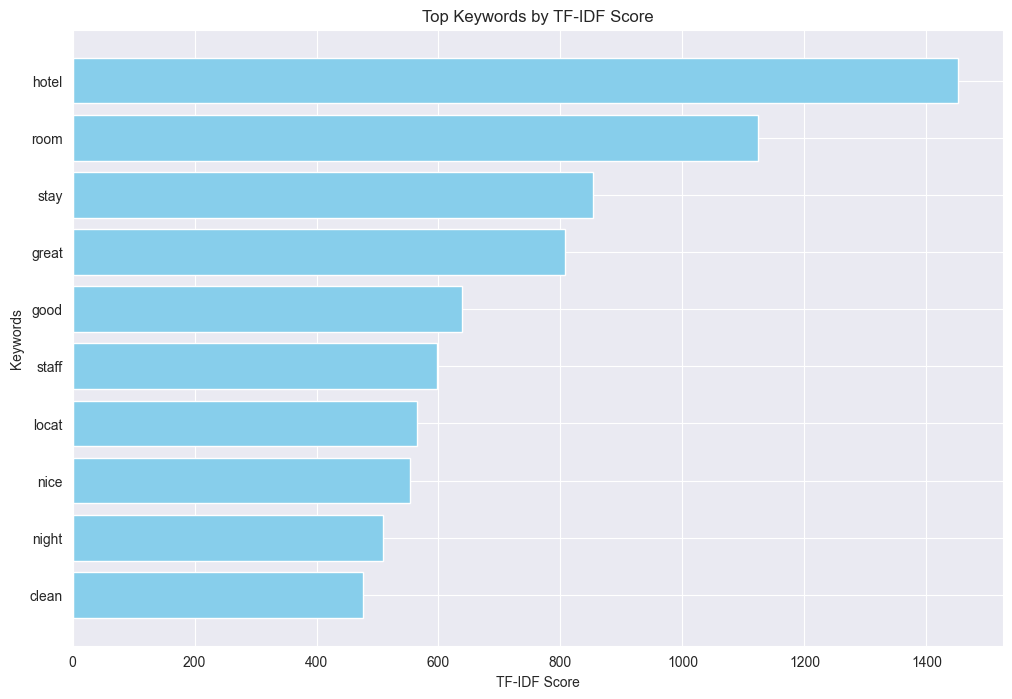

In [20]:
def plot_keyword_frequencies(keywords_df):
    plt.figure(figsize=(12, 8))
    plt.barh(keywords_df['Keyword'], keywords_df['Score'], color='skyblue')
    plt.xlabel('TF-IDF Score')
    plt.ylabel('Keywords')
    plt.title('Top Keywords by TF-IDF Score')
    plt.gca().invert_yaxis()  # Invert y-axis to have the highest scores on top
    plt.show()

plot_keyword_frequencies(keywords_df)

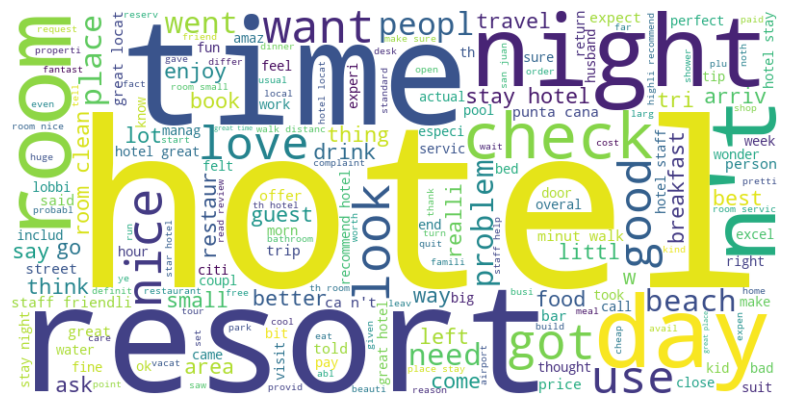

In [21]:
def generate_word_cloud(text):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

combined_text = " ".join(review for review in data['Review'])
generate_word_cloud(combined_text)


In [22]:
# Text preprocessing with TF-IDF
def preprocess_text(data):
    stop_words = stopwords.words('english')  # Use NLTK's stopwords
    vectorizer = TfidfVectorizer(stop_words=stop_words, max_features=1000)  # Limiting to top 1000 features
    tfidf_matrix = vectorizer.fit_transform(data['Review'])
    return tfidf_matrix, vectorizer.get_feature_names_out()

tfidf_matrix, feature_names = preprocess_text(data)

In [25]:
feature_names

array(['00', '10', '100', '11', '12', '14', '15', '18', '1st', '20',
       '2006', '2007', '2008', '24', '25', '2nd', '30', '3rd', '40', '45',
       '50', 'abl', 'absolut', 'accept', 'access', 'accommod', 'accomod',
       'activ', 'actual', 'ad', 'add', 'addit', 'adequ', 'adult', 'advic',
       'advis', 'advisor', 'afternoon', 'age', 'agent', 'ago', 'agre',
       'air', 'airport', 'al', 'alcohol', 'allow', 'alot', 'amaz',
       'amazing', 'amen', 'american', 'amsterdam', 'annoy', 'answer',
       'apart', 'appar', 'appear', 'appl', 'appoint', 'appreci', 'april',
       'area', 'arrang', 'arriv', 'art', 'ask', 'ate', 'atmospher',
       'attend', 'attent', 'attract', 'august', 'avail', 'available',
       'averag', 'avoid', 'away', 'awesom', 'awesome', 'bad', 'bag',
       'balconi', 'bali', 'bar', 'barcelona', 'bargain', 'bartend',
       'base', 'basic', 'bath', 'bathroom', 'bavaro', 'bay', 'beach',
       'beat', 'beauti', 'beautiful', 'bed', 'bedroom', 'beds', 'beer',
       '

In [32]:
tfidf_matrix

<20491x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 1132768 stored elements in Compressed Sparse Row format>

In [ ]:
def kmeans_clustering(tfidf_matrix, num_clusters=5):
    km = KMeans(n_clusters=num_clusters, random_state=42)
    km.fit(tfidf_matrix)
    clusters = km.labels_
    return clusters

clusters = kmeans_clustering(tfidf_matrix)
data['Cluster'] = clusters  # Add cluster information back to the dataframe

In [24]:
def examine_clusters(data, num_clusters):
    for i in range(num_clusters):
        cluster_samples = data[data['Cluster'] == i]['Review'].sample(5).values
        print(f"Cluster {i} Samples:")
        for sample in cluster_samples:
            print(f"- {sample}")
        print("\n")

examine_clusters(data, num_clusters=5)

Cluster 0 Samples:
- love room great locat stay 2004. love room spaciou clean, locat excel 5 minut darl harbour.would recommend apartments,
- great hotel great locat return 2 night break say hotel superb, great locat staff hotel average, tour berlin saw lot hotel picked, 2 restaur close entocot rememb fantast pizza reccomend, recoomend restaur maximiilion popular worst food had.if came berlin stay again.not museum person usual check point charli museum worth vist hotel load inoform board yard away fasinating,
- love, great locat great service, wife stay hotel duret januari 2007. trip pari friend recommend hotel location.w usual prefer marriott hilton travel littl bit reluct pick hotel know, stay hotel duret say best decis made.th hotel great room nice decor bathroom realli big.th staff hotel extrem friendli helpful, provid lot inform place visit restaurants.breakfast hotel great higli recommend try,
- nice hotel great locat stay club quarter hotel chose locat embarcadero area san franc

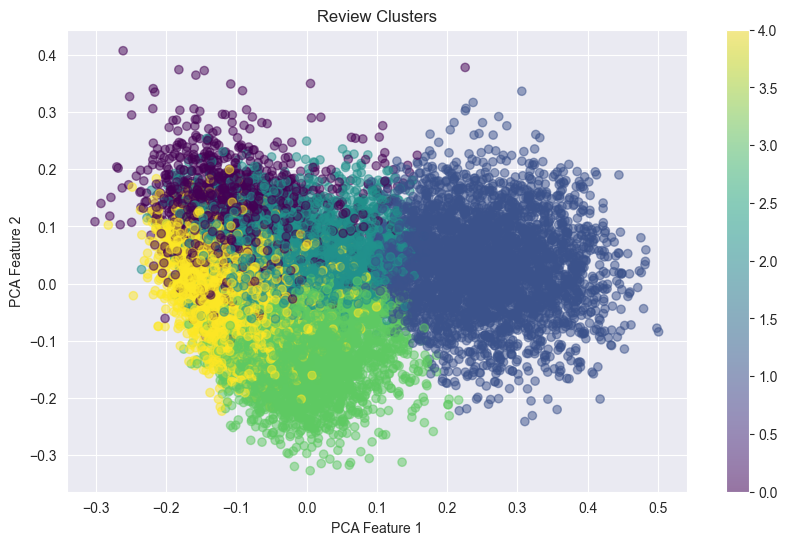

In [25]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def plot_clusters(tfidf_matrix, clusters):
    pca = PCA(n_components=2)
    reduced_features = pca.fit_transform(tfidf_matrix.toarray())
    
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=clusters, cmap='viridis', alpha=0.5)
    plt.colorbar(scatter)
    plt.title('Review Clusters')
    plt.xlabel('PCA Feature 1')
    plt.ylabel('PCA Feature 2')
    plt.show()

plot_clusters(tfidf_matrix, clusters)

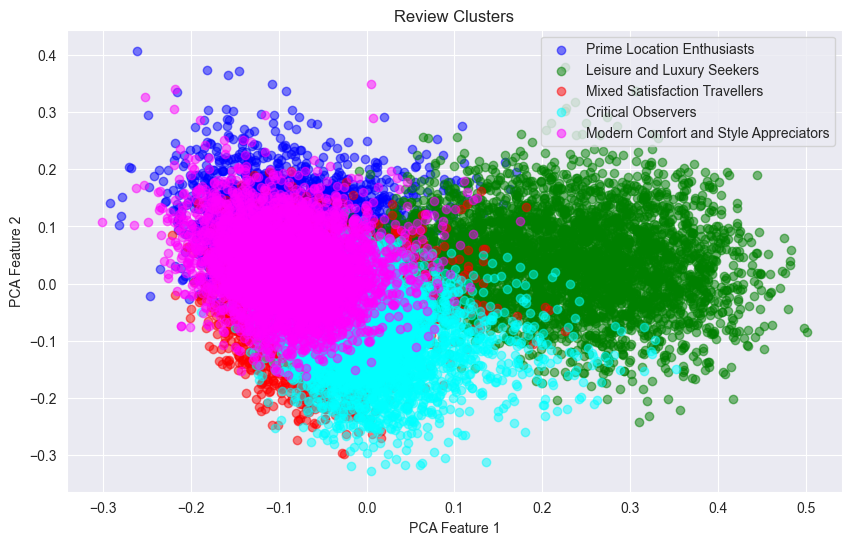

In [40]:
def plot_clusters(tfidf_matrix, clusters):
    pca = PCA(n_components=2)
    reduced_features = pca.fit_transform(tfidf_matrix.toarray())
    
    # Cluster names based on the interpretation provided
    cluster_names = {
        0: "Prime Location Enthusiasts",
        1: "Leisure and Luxury Seekers",
        2: "Mixed Satisfaction Travellers",
        3: "Critical Observers",
        4: "Modern Comfort and Style Appreciators"
    }

    plt.figure(figsize=(10, 6))
    colors = ['blue', 'green', 'red', 'cyan', 'magenta']
    
    # Scatter plot for each cluster
    for cluster_label, color in zip(cluster_names.keys(), colors):
        # Select only data points that belong to the current cluster
        ix = np.where(clusters == cluster_label)
        plt.scatter(reduced_features[ix, 0], reduced_features[ix, 1], c=color, label=cluster_names[cluster_label], alpha=0.5)
    
    plt.title('Review Clusters')
    plt.xlabel('PCA Feature 1')
    plt.ylabel('PCA Feature 2')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_clusters(tfidf_matrix, clusters)


In [26]:
import numpy as np

In [27]:
from sklearn.cluster import KMeans
from gensim.models import Word2Vec

processed_texts = texts

# Assume 'processed_texts' is a list of tokenized reviews
model = Word2Vec(processed_texts, vector_size=100, window=5, min_count=2, workers=4)

# Create a feature vector by averaging word vectors for each review
def document_vector(doc):
    return np.mean([model.wv[word] for word in doc if word in model.wv], axis=0)

doc_vectors = np.array([document_vector(doc) for doc in processed_texts])

# Clustering
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(doc_vectors)
clusters = kmeans.labels_


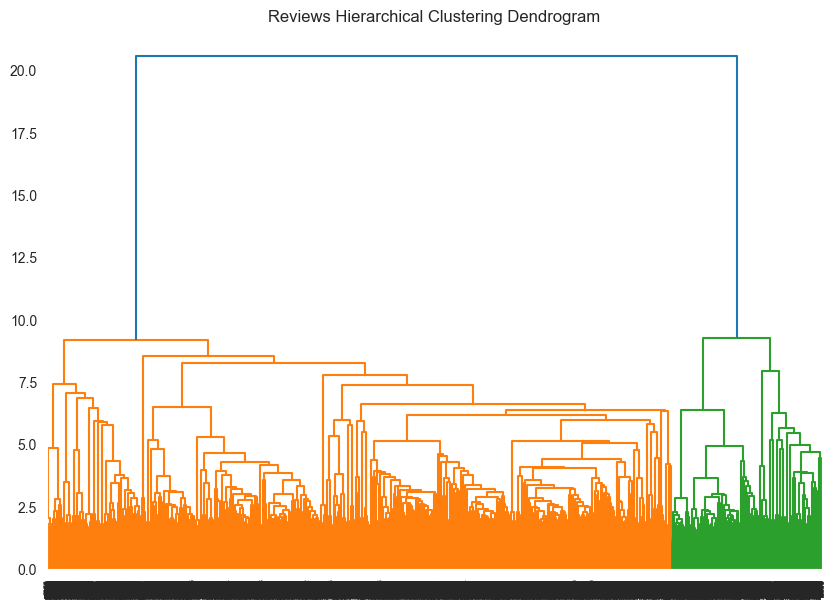

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch

# 'data' is the DataFrame and 'Review' contains the text data
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)  # Limiting to 1000 features for simplicity
X = vectorizer.fit_transform(data['Review'])

# Creating the model
model = AgglomerativeClustering(n_clusters=None, distance_threshold=0, metric='euclidean', linkage='ward')
model.fit(X.toarray())  # Convert sparse matrix to array to fit AgglomerativeClustering

# Plotting the dendrogram to visualize the clustering
plt.figure(figsize=(10, 7))
plt.title("Reviews Hierarchical Clustering Dendrogram")
dendrogram = sch.dendrogram(sch.linkage(X.toarray(), method='ward'))
plt.show()

In [10]:
plt.savefig('dendrogram')

<Figure size 640x480 with 0 Axes>

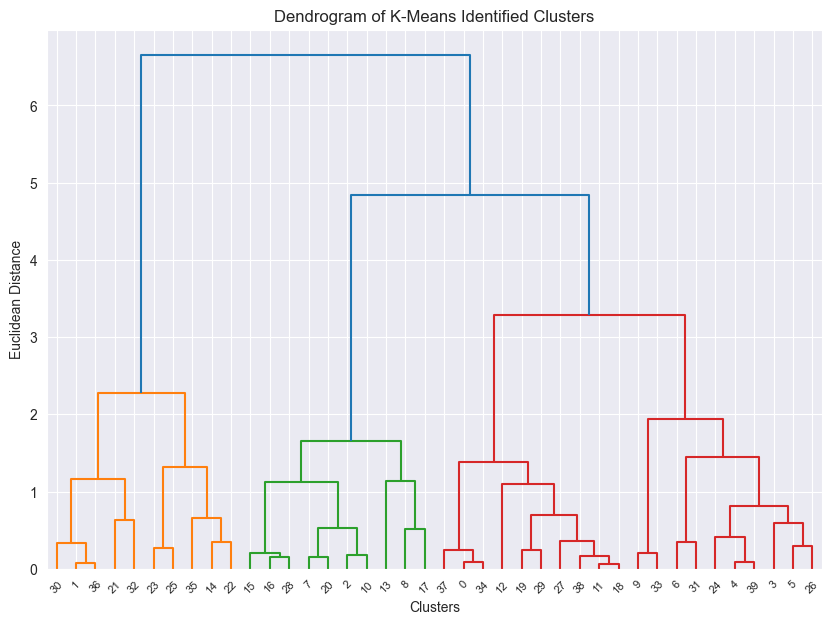

In [37]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

# 'doc_vectors' are derived from before
kmeans = KMeans(n_clusters=40, random_state=42)
kmeans.fit(doc_vectors)
centroids = kmeans.cluster_centers_

# Reduce dimensions for visualization if necessary
pca = PCA(n_components=2)
reduced_centroids = pca.fit_transform(centroids)

# Hierarchical clustering on the centroids
linkage_matrix = linkage(reduced_centroids, method='ward')
plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix)
plt.title('Dendrogram of K-Means Identified Clusters')
plt.xlabel('Clusters')
plt.ylabel('Euclidean Distance')
plt.show()


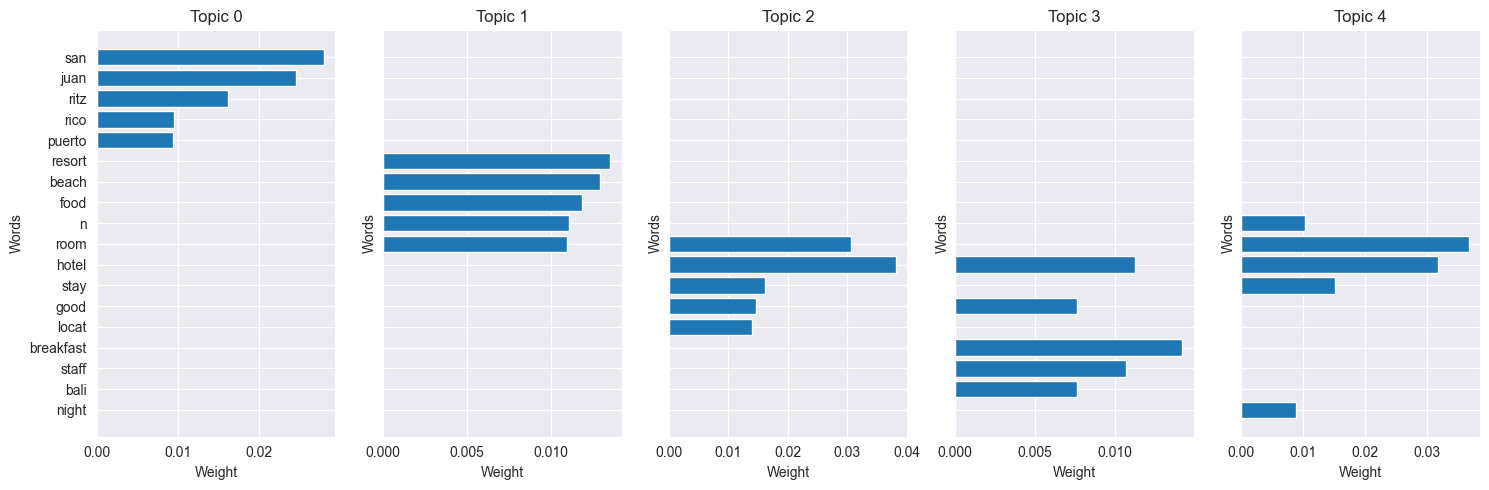

In [32]:
import matplotlib.pyplot as plt
import pandas as pd
from gensim import corpora, models
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

def preprocess_data(data):
    tokenizer = RegexpTokenizer(r'\w+')
    stop_words = set(stopwords.words('english'))
    data['tokens'] = data['Review'].apply(lambda x: [i for i in tokenizer.tokenize(x.lower()) if i not in stop_words])
    return data

# Assuming 'data' is your DataFrame and has been previously defined and loaded
complaint_reviews = data[data['Rating'] <= 3].copy()
complaint_reviews = preprocess_data(complaint_reviews)

dictionary = corpora.Dictionary(complaint_reviews['tokens'])
corpus = [dictionary.doc2bow(text) for text in complaint_reviews['tokens']]
ldamodel = models.LdaModel(corpus, num_topics=5, id2word=dictionary, passes=15)

# Extracting topics with words and probabilities
topics = ldamodel.show_topics(num_topics=5, num_words=5, formatted=False)

# Plotting
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 5), sharey=True)
for ax, topic in zip(axes, topics):
    topic_words = dict(topic[1])
    ax.barh(list(topic_words.keys()), list(topic_words.values()))
    ax.set_title('Topic ' + str(topic[0]))
    ax.invert_yaxis()  # Invert y-axis to have the highest probabilities on top
    ax.set_xlabel('Weight')
    ax.set_ylabel('Words')
plt.tight_layout()
plt.show()
